# Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Iterative Imputer & Random Forest
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

np.set_printoptions(suppress=True)

# Importing Data

In [2]:
raw_data = pd.read_csv('city_day.csv')

In [3]:
raw_data.head(5)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


# Data Preprocessing

- Drop AQI_Bucket, not needed for this task
- Drop any rows missing AQI values from simplicity

In [4]:
# Creating dataset from raw data, dropping AQI Bucket
data = raw_data.drop(['AQI_Bucket'], axis=1)

# Dropping rows with missing AQI values
data = data.dropna(subset=['AQI'])

# Convert the date to correct format
data['Date'] = pd.to_datetime(data['Date'])

- Reduce the data to 3 cities to reduce geographical variation: Jaipur, Amritsar, Thiruvananthapuram

In [5]:
regions = ['Amritsar', 'Amaravati', 'Jaipur']
data = data[data['City'].isin(regions)]

# Reset Index
data = data.reset_index(drop=True)

In [6]:
# Data summaries 
np.round(data.describe(),3)

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,3061,2971.000,3031.000,3006.000,3049.000,2727.000,3045.000,2979.000,2921.000,2976.000,2872.000,2855.000,1617.000,3061.000
mean,2019-01-04 22:02:23.482522112,50.159,107.412,13.281,24.375,30.779,17.991,0.665,11.003,35.744,2.194,4.145,4.885,118.074
min,2017-02-28 00:00:00,2.850,0.420,0.250,0.010,0.860,0.060,0.000,0.710,0.240,0.000,0.000,0.000,20.000
25%,2018-04-13 00:00:00,28.375,62.905,4.880,11.640,15.945,9.720,0.440,7.210,21.210,0.280,1.100,0.150,74.000
50%,2019-01-16 00:00:00,43.630,97.700,10.400,18.960,26.780,14.270,0.660,10.250,31.420,1.130,2.240,2.000,104.000
75%,2019-10-17 00:00:00,63.585,138.735,16.555,32.030,39.130,23.070,0.860,13.250,46.240,2.850,5.515,8.130,143.000
max,2020-07-01 00:00:00,868.660,917.080,103.440,237.270,150.960,129.460,3.830,67.260,172.280,53.890,76.320,137.450,869.000
std,NaN,35.894,62.526,12.981,17.878,22.030,12.889,0.440,5.941,20.465,3.328,5.079,8.077,65.766


### Missing Values

In [7]:
# Missing Values
data.isnull().sum()

City          0
Date          0
PM2.5        90
PM10         30
NO           55
NO2          12
NOx         334
NH3          16
CO           82
SO2         140
O3           85
Benzene     189
Toluene     206
Xylene     1444
AQI           0
dtype: int64

- As per EDA, drop Benzene, Toluene, Xylene as these do not directly correlate with AQI and have significant numbers of missing values

In [8]:
# Drop Benzene, Toluene, Xylene from data
data.drop(['Benzene', 'Toluene', 'Xylene'], axis=1, inplace=True)

### Add missing Values using Iterative Imputer package

In [9]:
# Drop the 'City' and 'Date' column, as it's not used for imputation
data_model = data.drop(['City', 'Date'], axis=1)

# Initialize the Iterative Imputer with a RandomForestRegressor
imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42)

# Apply the imputer to the dataset
df_imputed = pd.DataFrame(imputer.fit_transform(data_model), columns=data_model.columns)

# Display information about missing values after imputation
print(df_imputed.isnull().sum())

# Merge the imputed dataframe and the dataset
data_new = pd.concat([data[['City', 'Date']], df_imputed], axis=1)


PM2.5    0
PM10     0
NO       0
NO2      0
NOx      0
NH3      0
CO       0
SO2      0
O3       0
AQI      0
dtype: int64


/opt/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# Implementation of Weather Data

In [10]:
# Import Datasets
amarvati = pd.read_csv('amarvati.csv')
amritsar = pd.read_csv('amritsar.csv')
jaipur = pd.read_csv('jaipur.csv')

In [11]:
# Convert the 'Date' columns to datetime and remove timezones for consistency
data_new['Date'] = pd.to_datetime(data_new['Date']).dt.tz_localize(None)
amarvati['date'] = pd.to_datetime(amarvati['date']).dt.tz_localize(None)
jaipur['date'] = pd.to_datetime(jaipur['date']).dt.tz_localize(None)
amritsar['date'] = pd.to_datetime(amritsar['date']).dt.tz_localize(None)

# Rename the 'date' columns to 'Date' for consistency
amarvati.rename(columns={'date': 'Date'}, inplace=True)
jaipur.rename(columns={'date': 'Date'}, inplace=True)
amritsar.rename(columns={'date': 'Date'}, inplace=True)

# Add the 'City' column to each weather dataset
amarvati['City'] = 'Amaravati'
jaipur['City'] = 'Jaipur'
amritsar['City'] = 'Amritsar'

In [12]:
# Create a dictionary to map cities to the correct city csv file
city_data = {
    'Amaravati': amarvati,
    'Jaipur': jaipur,
    'Amritsar': amritsar
}

# Initialise empty lists for storing new data
temperature_mean = []
temperature_max = []
humidity_mean = []
humidity_max = []
dew_point_mean = []
dew_point_max = []
precipitation_sum = []
rain_sum = []
cloud_cover_sum = []
wind_speed_10m_mean = []
wind_speed_10m_max = []
wind_speed_100m_mean = []
wind_speed_100m_max = []

# Loop over each row in data_new_df
for index, row in data_new.iterrows():
    city = row['City']
    date = row['Date']
    
    # Check if the city has corresponding weather data
    if city in city_data:
        weather_df = city_data[city]
        # Find the matching row in the city's weather DataFrame
        match = weather_df[weather_df['Date'] == date]
        
        if not match.empty:
            # Append values to the lists if a match is found
            temperature_mean.append(match['temperature_mean'].values[0])
            temperature_max.append(match['temperature_max'].values[0])
            humidity_mean.append(match['humidity_mean'].values[0])
            humidity_max.append(match['humidity_max'].values[0])
            dew_point_mean.append(match['dew_point_mean'].values[0])
            dew_point_max.append(match['dew_point_max'].values[0])
            precipitation_sum.append(match['precipitation_sum'].values[0])
            rain_sum.append(match['rain_sum'].values[0])
            cloud_cover_sum.append(match['cloud_cover_sum'].values[0])
            wind_speed_10m_mean.append(match['wind_speed_10m_mean'].values[0])
            wind_speed_10m_max.append(match['wind_speed_10m_max'].values[0])
            wind_speed_100m_mean.append(match['wind_speed_100m_mean'].values[0])
            wind_speed_100m_max.append(match['wind_speed_100m_max'].values[0])
        else:
            # Append NaN if no match is found
            temperature_mean.append(float('nan'))
            temperature_max.append(float('nan'))
            humidity_mean.append(float('nan'))
            humidity_max.append(float('nan'))
            dew_point_mean.append(float('nan'))
            dew_point_max.append(float('nan'))
            precipitation_sum.append(float('nan'))
            rain_sum.append(float('nan'))
            cloud_cover_sum.append(float('nan'))
            wind_speed_10m_mean.append(float('nan'))
            wind_speed_10m_max.append(float('nan'))
            wind_speed_100m_mean.append(float('nan'))
            wind_speed_100m_max.append(float('nan'))
    else:
        # Append NaN if no matching city is found
        temperature_mean.append(float('nan'))
        temperature_max.append(float('nan'))
        humidity_mean.append(float('nan'))
        humidity_max.append(float('nan'))
        dew_point_mean.append(float('nan'))
        dew_point_max.append(float('nan'))
        precipitation_sum.append(float('nan'))
        rain_sum.append(float('nan'))
        cloud_cover_sum.append(float('nan'))
        wind_speed_10m_mean.append(float('nan'))
        wind_speed_10m_max.append(float('nan'))
        wind_speed_100m_mean.append(float('nan'))
        wind_speed_100m_max.append(float('nan'))

# Add the new data to the DataFrame
data_new['temperature_mean'] = temperature_mean
data_new['temperature_max'] = temperature_max
data_new['humidity_mean'] = humidity_mean
data_new['humidity_max'] = humidity_max
data_new['dew_point_mean'] = dew_point_mean
data_new['dew_point_max'] = dew_point_max
data_new['precipitation_sum'] = precipitation_sum
data_new['rain_sum'] = rain_sum
data_new['cloud_cover_sum'] = cloud_cover_sum
data_new['wind_speed_10m_mean'] = wind_speed_10m_mean
data_new['wind_speed_10m_max'] = wind_speed_10m_max
data_new['wind_speed_100m_mean'] = wind_speed_100m_mean
data_new['wind_speed_100m_max'] = wind_speed_100m_max

data_new.head(5)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,humidity_max,dew_point_mean,dew_point_max,precipitation_sum,rain_sum,cloud_cover_sum,wind_speed_10m_mean,wind_speed_10m_max,wind_speed_100m_mean,wind_speed_100m_max
0,Amaravati,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,...,89.346016,19.013000,21.263000,0.0,0.0,819.000009,9.180352,16.808570,15.935398,27.248455
1,Amaravati,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,...,95.198590,18.248417,21.063000,0.0,0.0,532.800023,7.759277,11.988594,14.097954,22.183128
2,Amaravati,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,...,97.275760,18.960917,21.463001,0.0,0.0,618.900014,6.287076,9.085988,11.361810,17.418196
3,Amaravati,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,...,94.871315,17.425500,21.013000,0.0,0.0,378.000013,7.019016,13.684735,13.233190,25.630886
4,Amaravati,2017-11-29,72.47,114.84,5.23,23.20,16.59,12.25,0.16,10.55,...,96.376900,17.617167,20.663000,0.0,0.0,189.000007,10.355873,14.186923,18.022025,23.904108


# Feature Selection

Applying Ridge & Lasso Regression to examine features

## Ridge Regression:

In [13]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [14]:
# Select features and target
X = data_new[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'temperature_mean', 'temperature_max', 'humidity_mean', 'humidity_max', 'dew_point_mean', 'dew_point_max', 'precipitation_sum', 'rain_sum', 'cloud_cover_sum', 'wind_speed_10m_mean', 'wind_speed_10m_max', 'wind_speed_100m_mean', 'wind_speed_100m_max']]
y = data_new['AQI'] 

In [15]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardise both sets of data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initiate Ridge Regression
ridge = Ridge(alpha=1) 

# Fit the model
ridge.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(ridge.coef_,4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

ridge_cv = cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_squared_error')
                           
# Output the results (MSE for each fold)
print("Cross-validated MSE (for each fold):", -ridge_cv)

# Mean of the cross-validation scores
print("Average MSE:", -ridge_cv.mean())

Mean Squared Error: 714.8898354682925
R-squared: 0.8103402340221986
                 Feature  Coefficient
0                  PM2.5      18.9347
1                   PM10      42.8007
2                     NO       3.6300
3                    NO2       4.9075
4                    NOx      -3.1024
5                    NH3      -2.1381
6                     CO       3.5156
7                    SO2       0.0098
8                     O3       6.4020
9       temperature_mean       0.4286
10       temperature_max       0.2653
11         humidity_mean       2.2322
12          humidity_max       1.8805
13        dew_point_mean       3.8574
14         dew_point_max      -5.5988
15     precipitation_sum      -0.1931
16              rain_sum      -0.1931
17       cloud_cover_sum       0.3614
18   wind_speed_10m_mean       1.9838
19    wind_speed_10m_max      -1.9164
20  wind_speed_100m_mean       0.2510
21   wind_speed_100m_max       1.5511
Cross-validated MSE (for each fold): [ 784.52547307 2116.9

### Alpha Tuning

In [16]:
from sklearn.model_selection import GridSearchCV

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the alpha values to test for tuning
alpha_values = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

# Initiate Ridge Regression and GridSearchCV
ridge = Ridge()

# Use GridSearchCV to tune alpha
ridge_cv = GridSearchCV(ridge, alpha_values, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

# Best alpha value
best_alpha = ridge_cv.best_params_['alpha']
print(f"Best alpha for Ridge: {best_alpha}")

# Use the best alpha to fit the model again
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge_best.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge_best.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(ridge_best.coef_, 4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

Best alpha for Ridge: 100
Mean Squared Error: 707.5100734480131
R-squared: 0.8122980796486107
                 Feature  Coefficient
0                  PM2.5      19.4432
1                   PM10      40.2657
2                     NO       2.6897
3                    NO2       4.0629
4                    NOx      -0.9479
5                    NH3      -1.8538
6                     CO       3.6153
7                    SO2       0.0118
8                     O3       6.3902
9       temperature_mean      -0.1859
10       temperature_max      -0.2634
11         humidity_mean       1.5428
12          humidity_max       1.7248
13        dew_point_mean       1.5592
14         dew_point_max      -2.2813
15     precipitation_sum      -0.1358
16              rain_sum      -0.1358
17       cloud_cover_sum       0.0766
18   wind_speed_10m_mean       1.1943
19    wind_speed_10m_max      -1.1653
20  wind_speed_100m_mean       0.6718
21   wind_speed_100m_max       0.9361


## Lasso Regression:

In [17]:
from sklearn.linear_model import Lasso

# Using majority of the same code as above:
lasso = Lasso(alpha=0.1)

# Fit the model
lasso.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = lasso.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(lasso.coef_,4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

lasso_cv = cross_val_score(lasso, X, y, cv=5, scoring='neg_mean_squared_error')
                           
# Output the results (MSE for each fold)
print("Cross-validated MSE (for each fold):", -lasso_cv)

# Mean of the cross-validation scores
print("Average MSE:", -lasso_cv.mean())

Mean Squared Error: 712.5025526103241
R-squared: 0.8109735784701142
                 Feature  Coefficient
0                  PM2.5      18.9287
1                   PM10      42.7005
2                     NO       2.5704
3                    NO2       3.9986
4                    NOx      -1.4336
5                    NH3      -1.9465
6                     CO       3.3648
7                    SO2       0.0589
8                     O3       6.3345
9       temperature_mean      -0.0000
10       temperature_max      -0.0000
11         humidity_mean       2.4365
12          humidity_max       1.3955
13        dew_point_mean       0.0000
14         dew_point_max      -1.2038
15     precipitation_sum      -0.1671
16              rain_sum      -0.0000
17       cloud_cover_sum       0.1569
18   wind_speed_10m_mean       0.4005
19    wind_speed_10m_max      -0.3085
20  wind_speed_100m_mean       1.5533
21   wind_speed_100m_max       0.0870
Cross-validated MSE (for each fold): [ 780.55316302 2120.1

### Alpha Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the alpha values to test for tuning
alpha_values = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

# Initiate Ridge Regression and GridSearchCV
lasso = Lasso()

# Use GridSearchCV to tune alpha
lasso_cv = GridSearchCV(lasso, alpha_values, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha value
best_alpha = lasso_cv.best_params_['alpha']
print(f"Best alpha for Lasso: {best_alpha}")

# Use the best alpha to fit the model again
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso_best.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge_best.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(lasso_best.coef_, 4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

Best alpha for Lasso: 1
Mean Squared Error: 707.4988197108421
R-squared: 0.8122980796486107
                 Feature  Coefficient
0                  PM2.5      18.2336
1                   PM10      42.3349
2                     NO       0.4797
3                    NO2       2.4446
4                    NOx       0.0000
5                    NH3      -0.0000
6                     CO       2.8539
7                    SO2       0.0000
8                     O3       5.0229
9       temperature_mean      -0.0000
10       temperature_max      -1.1287
11         humidity_mean       0.0000
12          humidity_max       1.2888
13        dew_point_mean      -0.0000
14         dew_point_max      -0.0000
15     precipitation_sum       0.0000
16              rain_sum       0.0000
17       cloud_cover_sum       0.0000
18   wind_speed_10m_mean       0.0000
19    wind_speed_10m_max       0.0000
20  wind_speed_100m_mean       0.2584
21   wind_speed_100m_max       0.0000


- As PM2.5 particles are included in PM10, we face the issue of multicolinearity. By applying PCA onto these features we can reduce this.

- This improves the Ridge and Lasso Regression models but will sacrifice interpretability

## Principle Component Analysis

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Standardize the data
scaler = StandardScaler()
pm_data_scaled = scaler.fit_transform(data_new[['PM2.5', 'PM10']])

# Step 2: Apply PCA to PM2.5 and PM10
pca = PCA(n_components=2)  # Use 2 components because we have 2 features
pm_pca = pca.fit_transform(pm_data_scaled)

# Create a new DataFrame with the principal components
pm_pca_df = pd.DataFrame(pm_pca, columns=['PC1', 'PC2'])

# Explained variance to understand how much information is captured by each component
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance}")

# Keep PC1 and drop both PM2.5 and PM10
X.drop(['PM2.5', 'PM10'], axis=1, inplace=True)

# Add PC1
X.insert(0, 'PC1', pm_pca[:, 0])

Explained Variance Ratio: [0.85227251 0.14772749]


/var/folders/8h/gtndp3dj3pl2vs4brgn9zq9h0000gp/T/ipykernel_33250/408682948.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['PM2.5', 'PM10'], axis=1, inplace=True)


### Ridge

In [20]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardise both sets of data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initiate Ridge Regression
ridge = Ridge(alpha=1.0) 

# Fit the model
ridge.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(ridge.coef_,4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

ridge_cv = cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_squared_error')
                           
# Output the results (MSE for each fold)
print("Cross-validated MSE (for each fold):", -ridge_cv)

# Mean of the cross-validation scores
print("Average MSE:", -ridge_cv.mean())

Mean Squared Error: 627.1008777524146
R-squared: 0.8336305821986023
                 Feature  Coefficient
0                    PC1      55.8033
1                     NO       3.5722
2                    NO2       4.8283
3                    NOx      -1.7277
4                    NH3      -2.5497
5                     CO       4.7139
6                    SO2      -1.3840
7                     O3       7.1235
8       temperature_mean      -5.7314
9        temperature_max       0.8435
10         humidity_mean      -1.5633
11          humidity_max       1.3196
12        dew_point_mean       8.5230
13         dew_point_max      -3.1947
14     precipitation_sum       0.0885
15              rain_sum       0.0885
16       cloud_cover_sum      -0.8548
17   wind_speed_10m_mean       2.5595
18    wind_speed_10m_max      -1.6153
19  wind_speed_100m_mean      -0.9256
20   wind_speed_100m_max       2.4149
Cross-validated MSE (for each fold): [ 665.88083357 1811.90704613 1182.85104781  705.57631079  5

In [21]:
from sklearn.model_selection import GridSearchCV

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the alpha values to test for tuning
alpha_values = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

# Initiate Ridge Regression and GridSearchCV
ridge = Ridge()

# Use GridSearchCV to tune alpha
ridge_cv = GridSearchCV(ridge, alpha_values, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

# Best alpha value
best_alpha = ridge_cv.best_params_['alpha']
print(f"Best alpha for Ridge: {best_alpha}")

# Use the best alpha to fit the model again
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge_best.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge_best.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(ridge_best.coef_, 4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

Best alpha for Ridge: 10
Mean Squared Error: 627.8042929064565
R-squared: 0.8334439666574631
                 Feature  Coefficient
0                    PC1      55.5202
1                     NO       3.4941
2                    NO2       4.7450
3                    NOx      -1.4831
4                    NH3      -2.5204
5                     CO       4.7188
6                    SO2      -1.3633
7                     O3       7.1369
8       temperature_mean      -3.2007
9        temperature_max       0.1325
10         humidity_mean      -0.2417
11          humidity_max       1.4172
12        dew_point_mean       6.1475
13         dew_point_max      -2.8251
14     precipitation_sum       0.0636
15              rain_sum       0.0636
16       cloud_cover_sum      -1.0095
17   wind_speed_10m_mean       2.4161
18    wind_speed_10m_max      -1.4726
19  wind_speed_100m_mean      -0.7773
20   wind_speed_100m_max       2.2802


### Lasso

In [22]:
# Using majority of the same code as above:
lasso = Lasso(alpha=0.1)

# Fit the model
lasso.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = lasso.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(lasso.coef_,4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

lasso_cv = cross_val_score(lasso, X, y, cv=5, scoring='neg_mean_squared_error')
                           
# Output the results (MSE for each fold)
print("Cross-validated MSE (for each fold):", -lasso_cv)

# Mean of the cross-validation scores
print("Average MSE:", -lasso_cv.mean())

Mean Squared Error: 624.4432369731543
R-squared: 0.834335652411158
                 Feature  Coefficient
0                    PC1      55.7421
1                     NO       2.6461
2                    NO2       3.8814
3                    NOx      -0.0000
4                    NH3      -2.3965
5                     CO       4.4967
6                    SO2      -1.1468
7                     O3       7.0591
8       temperature_mean      -0.0221
9        temperature_max      -0.4304
10         humidity_mean       1.7901
11          humidity_max       1.3792
12        dew_point_mean       0.4521
13         dew_point_max      -0.0000
14     precipitation_sum      -0.0000
15              rain_sum      -0.0000
16       cloud_cover_sum      -0.7377
17   wind_speed_10m_mean       1.2547
18    wind_speed_10m_max      -0.2035
19  wind_speed_100m_mean       0.1649
20   wind_speed_100m_max       1.0949
Cross-validated MSE (for each fold): [ 662.18637073 1814.63523434 1182.72703608  701.45804575  52

In [23]:
from sklearn.model_selection import GridSearchCV

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the alpha values to test for tuning
alpha_values = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

# Initiate Ridge Regression and GridSearchCV
lasso = Lasso()

# Use GridSearchCV to tune alpha
lasso_cv = GridSearchCV(lasso, alpha_values, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha value
best_alpha = lasso_cv.best_params_['alpha']
print(f"Best alpha for Lasso: {best_alpha}")

# Use the best alpha to fit the model again
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso_best.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge_best.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(lasso_best.coef_, 4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

Best alpha for Lasso: 0.1
Mean Squared Error: 624.4432369731543
R-squared: 0.8334439666574631
                 Feature  Coefficient
0                    PC1      55.7421
1                     NO       2.6461
2                    NO2       3.8814
3                    NOx      -0.0000
4                    NH3      -2.3965
5                     CO       4.4967
6                    SO2      -1.1468
7                     O3       7.0591
8       temperature_mean      -0.0221
9        temperature_max      -0.4304
10         humidity_mean       1.7901
11          humidity_max       1.3792
12        dew_point_mean       0.4521
13         dew_point_max      -0.0000
14     precipitation_sum      -0.0000
15              rain_sum      -0.0000
16       cloud_cover_sum      -0.7377
17   wind_speed_10m_mean       1.2547
18    wind_speed_10m_max      -0.2035
19  wind_speed_100m_mean       0.1649
20   wind_speed_100m_max       1.0949


- From here we can look to remove x,y and z features

## Feature Removal

In [24]:
# Based off of Ridge & Lasso Regression, we can remove certain components
columns_to_drop = ['NOx', 'temperature_mean', 'dew_point_max', 'precipitation_sum', 'rain_sum', 'wind_speed_100m_mean', 'wind_speed_10m_max', 'temperature_max', 'dew_point_mean'] # Removing all zeroed components & any low coefficient features

# Drop columns on original data
#model_data = data_new.drop(columns_to_drop, axis=1) # This data does not include Principle Component Analysis

# Apply Principle Component to original data and drop columns
model_data = data_new.drop(['PM2.5', 'PM10'], axis=1)
# Add PC1
model_data.insert(2, 'PC1', pm_pca[:, 0])
model_data.drop(columns_to_drop, axis=1, inplace=True)

In [25]:
model_data.to_csv('model_data.csv', index=True)

model_data.head(1)

,City,Date,PC1,NO,NO2,NH3,CO,SO2,O3,AQI,humidity_mean,humidity_max,cloud_cover_sum,wind_speed_10m_mean,wind_speed_100m_max
0,Amaravati,2017-11-25,0.823624,1.44,20.5,10.72,0.12,15.24,127.09,184.0,64.906533,89.346016,819.000009,9.180352,27.248455


# SMOTER for Data Imbalance

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AQI', ylabel='Count'>

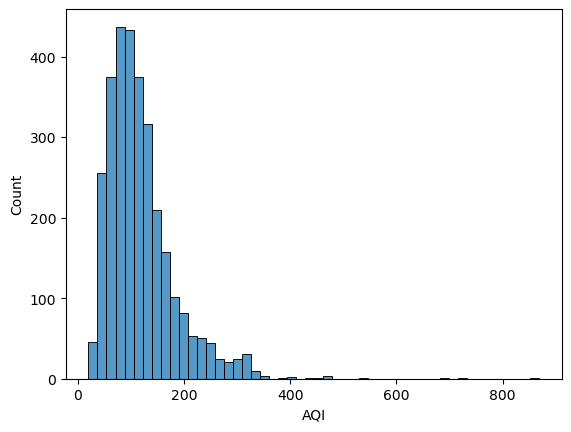

In [26]:
# Distribution of AQI
sns.histplot(model_data['AQI'], bins=50)

In [83]:
import smogn

# Implement SMOTER to synthesise extreme data points due to skewness of AQI
model_data_smoter = smogn.smoter(data=model_data,y='AQI', samp_method='extreme')

# Print sizes of dataframe
print(model_data_smoter.shape, data_new.shape)

r_index: 100%|##########| 43/43 [00:00<00:00, 1725.72it/s]

(4739, 15) (3061, 25)


In [79]:
data_new

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,humidity_max,dew_point_mean,dew_point_max,precipitation_sum,rain_sum,cloud_cover_sum,wind_speed_10m_mean,wind_speed_10m_max,wind_speed_100m_mean,wind_speed_100m_max
0,Amaravati,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,...,89.346016,19.013000,21.263000,0.0,0.0,819.000009,9.180352,16.808570,15.935398,27.248455
1,Amaravati,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,...,95.198590,18.248417,21.063000,0.0,0.0,532.800023,7.759277,11.988594,14.097954,22.183128
2,Amaravati,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,...,97.275760,18.960917,21.463001,0.0,0.0,618.900014,6.287076,9.085988,11.361810,17.418196
3,Amaravati,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,...,94.871315,17.425500,21.013000,0.0,0.0,378.000013,7.019016,13.684735,13.233190,25.630886
4,Amaravati,2017-11-29,72.47,114.84,5.23,23.20,16.59,12.25,0.16,10.55,...,96.376900,17.617167,20.663000,0.0,0.0,189.000007,10.355873,14.186923,18.022025,23.904108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056,Jaipur,2020-06-27,28.33,76.66,6.15,14.72,18.14,21.82,0.59,9.96,...,92.568756,24.902417,25.704500,2.6,2.6,1160.500034,13.700709,20.873790,23.140423,28.963785
3057,Jaipur,2020-06-28,23.76,67.44,5.60,14.05,17.20,20.41,0.50,8.93,...,93.412636,24.931583,26.154501,10.3,10.3,1071.400025,10.698332,18.079027,18.079032,30.007679
3058,Jaipur,2020-06-29,30.58,77.30,6.21,16.63,19.50,22.70,0.55,10.59,...,97.047820,24.685750,25.854500,7.3,7.3,1164.600019,6.531334,12.181625,11.079909,19.453327
3059,Jaipur,2020-06-30,30.03,64.26,5.48,13.77,16.94,19.79,0.67,10.36,...,95.913940,24.933667,25.604500,2.2,2.2,1011.899999,6.160173,10.703569,11.155103,16.935310


In [80]:
model_data_smoter

,City,Date,PC1,NO,NO2,NH3,CO,SO2,O3,AQI,humidity_mean,humidity_max,cloud_cover_sum,wind_speed_10m_mean,wind_speed_100m_max
0,Amaravati,2018-12-04 04:31:06.220569600,1.380233,4.139891,87.230046,1.856056,1.122237,13.502333,33.040825,208.787600,67.728518,82.397022,1765.715600,10.490651,23.520370
1,Amaravati,2018-12-03 18:11:19.203663616,1.343673,4.115828,87.033134,1.577710,1.126143,13.704345,33.368187,193.554987,67.364475,82.191324,1770.745571,10.607287,23.829322
2,Amaravati,2018-12-12 22:19:42.468012800,1.625765,3.472994,63.260210,15.126610,1.101881,21.892754,38.485634,194.361323,50.525091,78.062946,1282.263607,11.408205,23.189387
3,Amaravati,2018-12-06 13:06:29.097780480,1.514465,4.395540,91.575542,5.585385,0.812947,11.277523,28.752434,191.054849,74.821580,91.565805,1025.465271,7.912814,17.744277
4,Amaravati,2018-12-11 09:55:15.554727680,1.579364,3.577803,67.284339,12.815287,1.103261,20.487481,37.558898,194.361323,53.404399,78.726746,1371.365388,11.283131,23.311255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056,Jaipur,2020-06-27 00:00:00,-0.772288,6.150000,14.720000,21.820000,0.590000,9.960000,39.120000,89.000000,82.146618,92.568756,1160.500034,13.700709,28.963785
3057,Jaipur,2020-06-28 00:00:00,-0.967482,5.600000,14.050000,20.410000,0.500000,8.930000,34.400000,75.000000,85.573320,93.412636,1071.400025,10.698332,30.007679
3058,Jaipur,2020-06-29 00:00:00,-0.720350,6.210000,16.630000,22.700000,0.550000,10.590000,39.210000,69.000000,84.936178,97.047820,1164.600019,6.531334,19.453327
3059,Jaipur,2020-06-30 00:00:00,-0.878962,5.480000,13.770000,19.790000,0.670000,10.360000,50.710000,79.000000,84.108397,95.913940,1011.899999,6.160173,16.935310


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AQI', ylabel='Count'>

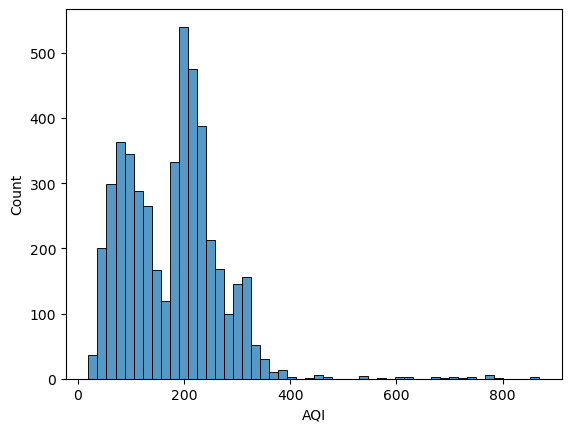

In [101]:
# Distribtion of AQI after SMOTER
sns.histplot(model_data_smoter['AQI'], bins=50)

# Model Evaluation Without SMOTER

### Metrics for Evaluation:
- RMSE
- MSE
- R-Squared

## Benchmark (Ordinary Least Squares)

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
linear_model = LinearRegression()

# Fit the model on the data
linear_model.fit(X_train, y_train)

# Make predictions
y_pred = linear_model.predict(X_test)

# Perform cross-validation
ols_cv = cross_val_score(linear_model, X, y, cv=5, scoring='neg_mean_squared_error')
ols_cv_r2 = cross_val_score(linear_model, X, y, cv=5, scoring='r2')

In [30]:
# Evaluate the model performance
ols_mse = mean_squared_error(y_test, y_pred)
ols_rmse = np.sqrt(ols_mse)
ols_r2 = r2_score(y_test, y_pred)


## Random Forest Regressor

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)

# Cross Validate
rf_cv = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
rf_cv_r2 = cross_val_score(rf, X, y, cv=5, scoring='r2')


In [32]:
# Evaluate Model Performance
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, y_pred_rf)

### Parameter Tuning using RandomisedSearch

In [33]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Prepare data
X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),  # Random number of trees between 50 and 200
    'max_depth': randint(5, 20),  # Random depth between 5 and 20
    'min_samples_split': randint(2, 10),  # Random min samples for split between 2 and 10
    'min_samples_leaf': randint(1, 10),  # Random min samples at leaf between 1 and 10
    'max_features': ['sqrt', 'log2', None]  # Replace 'auto' with 'sqrt', 'log2', or None
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                   n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                   random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_train, y_train)

# Access cross val results
rf_results = random_search.cv_results_

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Use the best model to make predictions
best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)


Best parameters found: {'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}


In [34]:
# Evaluate the best model
rf_mse_best = mean_squared_error(y_test, y_pred_best_rf)
rf_rmse_best = np.sqrt(rf_mse_best)
rf_r2_best = r2_score(y_test, y_pred_best_rf)

## Support Vector Regression

In [35]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (SVR requires standardized input)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the Support Vector Regression model
svr = SVR(kernel='rbf')  # Using RBF kernel for non-linear relationships
svr.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_svr = svr.predict(X_test_scaled)

# Cross Validate
svr_cv = cross_val_score(svr, X, y, cv=5, scoring='neg_mean_squared_error')
svr_cv_r2 = cross_val_score(svr, X, y, cv=5, scoring='r2')


In [36]:
# Evaluate Model
svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_rmse = np.sqrt(svr_mse)
svr_r2 = r2_score(y_test, y_pred_svr)

### Parameter Tuning using RandomisedSearch

In [37]:
from scipy.stats import uniform

# Prepare the data
X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (SVR requires standardized input)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Support Vector Regressor (SVR)
svr = SVR()

# Define the hyperparameter grid
param_dist = {
    'C': uniform(0.1, 100),  # Regularization parameter between 0.1 and 100
    'epsilon': uniform(0.01, 1),  # Epsilon value for margin
    'gamma': ['scale', 'auto'],  # Gamma parameter for the RBF kernel
    'kernel': ['rbf', 'linear']  # Kernel options
}

# Use RandomizedSearchCV for tuning
random_search_svr = RandomizedSearchCV(svr, param_distributions=param_dist, 
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                       random_state=42, n_jobs=-1)

# Fit the random search model
random_search_svr.fit(X_train_scaled, y_train)

# Access cross validation results
svr_results = random_search_svr.cv_results_

# Get the best parameters
best_params_svr = random_search_svr.best_params_
print(f"Best parameters found: {best_params_svr}")

# Use the best model to make predictions
best_svr = random_search_svr.best_estimator_
y_pred_best_svr = best_svr.predict(X_test_scaled)



Best parameters found: {'C': 37.55401188473625, 'epsilon': 0.9607143064099162, 'gamma': 'scale', 'kernel': 'linear'}


In [38]:
# Evaluate the best model
svr_mse_best = mean_squared_error(y_test, y_pred_best_svr)
svr_rmse_best = np.sqrt(svr_mse_best)
svr_r2_best = r2_score(y_test, y_pred_best_svr)

## XGBoost 

In [39]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data
X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor with default or manually chosen parameters
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Perform cross-validation for MSE and R-squared
xgb_cv_mse = cross_val_score(xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')
xgb_cv_r2 = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')



In [40]:
# Evaluate the Model
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, y_pred_xgb)

### Parameter Tuning using RandomisedSearch

In [41]:
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data
X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),  # Number of trees (estimators)
    'learning_rate': uniform(0.01, 0.3),  # Learning rate (eta)
    'max_depth': randint(3, 10),  # Depth of trees
    'subsample': uniform(0.5, 0.5),  # Subsampling of rows
    'colsample_bytree': uniform(0.5, 0.5),  # Subsampling of columns
    'reg_alpha': uniform(0, 0.1),  # L1 regularization (alpha)
    'reg_lambda': uniform(0.1, 1.0),  # L2 regularization (lambda)
}

# Use RandomizedSearchCV for tuning
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_dist, 
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                       random_state=42, n_jobs=-1)

# Fit the random search model
random_search_xgb.fit(X_train, y_train)

# Access cross validation results
xgb_results = random_search_xgb.cv_results_

# Get the best parameters
best_params_xgb = random_search_xgb.best_params_
print(f"Best parameters found: {best_params_xgb}")

# Use the best model to make predictions
best_xgb = random_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

Best parameters found: {'colsample_bytree': 0.8035171238433423, 'learning_rate': 0.092799754606763, 'max_depth': 7, 'n_estimators': 64, 'reg_alpha': 0.01652669390630025, 'reg_lambda': 0.11563640674119394, 'subsample': 0.7117007403531848}


In [42]:
# Evaluate the Model
xgb_mse_best = mean_squared_error(y_test, y_pred_best_xgb)
xgb_rmse_best = np.sqrt(xgb_mse_best)
xgb_r2_best = r2_score(y_test, y_pred_best_xgb)

## Stacked Neural Network + XGBoost

In [43]:
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor

# Initialize XGBoost and Neural Network as base learners
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
nn_model = MLPRegressor(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=5000, random_state=42)

# Create the stacking model using Linear Regression as the meta-model
stacked_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('nn', nn_model)],
    final_estimator=LinearRegression()
)

X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the stacked model
stacked_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred_stacked = stacked_model.predict(X_test)

hybrid_cv = cross_val_score(stacked_model, X, y, cv=5, scoring='neg_mean_squared_error')
hybrid_cv_r2 = cross_val_score(stacked_model, X, y, cv=5, scoring='r2')


In [44]:
# Evaluate the Model
stacked_mse = mean_squared_error(y_test, y_pred_stacked)
stacked_rmse = np.sqrt(stacked_mse)
stacked_r2 = r2_score(y_test, y_pred_stacked)

### Parameter Tuning using RandomSearch

In [45]:
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform, randint

# Prepare data
X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize base models
xgb_model = xgb.XGBRegressor(random_state=42)
nn_model = MLPRegressor(max_iter=5000, random_state=42, verbose=False)

# Define the stacking model
stacked_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('nn', nn_model)],
    final_estimator=LinearRegression()
)

# Define hyperparameter grid for RandomizedSearchCV
param_grid = {
    'xgb__n_estimators': randint(50, 200),
    'xgb__learning_rate': uniform(0.01, 0.3),
    'xgb__max_depth': randint(3, 10),
    'xgb__subsample': uniform(0.5, 0.5),  # Generates values strictly between 0.5 and 1.0
    'xgb__colsample_bytree': uniform(0.5, 0.5),  # Same, strictly between 0.5 and 1.0
    
    'nn__hidden_layer_sizes': [(50,), (100,), (100, 100)],
    'nn__activation': ['relu'],
    'nn__alpha': uniform(0.0001, 0.01),  # Reasonable regularization range
    'nn__solver': ['adam']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=stacked_model, 
                                   param_distributions=param_grid, 
                                   n_iter=20, 
                                   cv=5, 
                                   scoring='neg_mean_squared_error',
                                   random_state=42, 
                                   n_jobs=1,  # No parallel jobs
                                   error_score='raise')  # Raise errors

# Fit the random search model
random_search.fit(X_train, y_train)

# Access cross-validation results
stacked_restults = random_search.cv_results_

# Get the best parameters and best model
best_stacked_model = random_search.best_estimator_
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Make predictions and evaluate the tuned stacked model
y_pred_best_stacked = best_stacked_model.predict(X_test)


Best parameters found: {'nn__activation': 'relu', 'nn__alpha': 0.006475574713552132, 'nn__hidden_layer_sizes': (100, 100), 'nn__solver': 'adam', 'xgb__colsample_bytree': 0.7806217129238506, 'xgb__learning_rate': 0.12487806242613694, 'xgb__max_depth': 9, 'xgb__n_estimators': 180, 'xgb__subsample': 0.8803925243084487}


In [48]:
# Evaluate the model
stacked_mse_best = mean_squared_error(y_test, y_pred_best_stacked)
stacked_rmse_best = np.sqrt(stacked_mse_best)
stacked_r2_best = r2_score(y_test, y_pred_best_stacked)

# Model Comparisons

In [49]:
from scipy.stats import f_oneway

rf_results_mse = rf_results['mean_test_score']
svr_results_mse = svr_results['mean_test_score']
xgb_results_mse = xgb_results['mean_test_score']
stacked_restults_mse = stacked_restults['mean_test_score']

# Perform ANOVA test
f_statistic, p_value = f_oneway(rf_results_mse, svr_results_mse, xgb_results_mse, stacked_restults_mse)

# Output the results
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Interpretation of ANOVA test result
if p_value < 0.05:
    print("There is a statistically significant difference between the models.")
else:
    print("No statistically significant difference between the models.")


F-statistic: 23.33233531638366
P-value: 8.293453264143274e-11
There is a statistically significant difference between the models.


In [73]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Example MSE data for three models
# Replace with your cross-validated MSE data
mse_data = np.concatenate([rf_results_mse, svr_results_mse, xgb_results_mse, stacked_restults_mse])

# Corresponding labels for the models
model_labels = (['Random Forest'] * len(rf_results_mse)) + (['SVG'] * len(svr_results_mse)) + (['XGBoost'] * len(xgb_results_mse) + (['Hybrid Model'] * len(stacked_restults_mse)))

# Create a DataFrame to hold the MSE values and corresponding model labels
df = pd.DataFrame({'MSE': mse_data, 'Model': model_labels})

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['MSE'], groups=df['Model'], alpha=0.05)

# Display the test results
print(tukey)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1        group2    meandiff p-adj    lower    upper   reject
---------------------------------------------------------------------
 Hybrid Model Random Forest -165.775    0.0 -240.2998 -91.2501   True
 Hybrid Model           SVG -138.661    0.0 -213.1858 -64.1361   True
 Hybrid Model       XGBoost  26.8766 0.7794  -47.6482 101.4014  False
Random Forest           SVG   27.114 0.7748  -47.4108 101.6389  False
Random Forest       XGBoost 192.6516    0.0  118.1267 267.1764   True
          SVG       XGBoost 165.5375    0.0   91.0127 240.0624   True
---------------------------------------------------------------------


In [50]:
# Dataframe for Metric Comparison without SMOTER

models = ['OLS', 'Random Forest', 'SVR', 'XGB', 'XGB + NN']
mse = [ols_mse, rf_mse_best, svr_mse_best, xgb_mse_best, stacked_mse_best]
rmse = [ols_rmse, rf_rmse_best, svr_rmse_best, xgb_rmse_best, stacked_rmse_best]
r2 = [ols_r2, rf_r2_best, svr_r2_best, xgb_r2_best, stacked_r2_best]

# Create the DataFrame
df_results = pd.DataFrame({
    'Model': models,
    'MSE': mse,
    'RMSE': rmse,
    'R²': r2
})

# Display the DataFrame
df_results

,Model,MSE,RMSE,R²
0,OLS,626.176561,25.023520,0.833876
1,Random Forest,594.982597,24.392265,0.842152
2,SVR,632.752777,25.154578,0.832131
3,XGB,700.701540,26.470768,0.814104
4,XGB + NN,678.361974,26.045383,0.820031


# Model Evaluation with SMOTER

## Benchmark (Ordinary Least Squares)

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = model_data_smoter.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data_smoter['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
linear_model = LinearRegression()

# Fit the model on the data
linear_model.fit(X_train, y_train)

# Make predictions
y_pred = linear_model.predict(X_test)

# Perform cross-validation
ols_cv_smoter = cross_val_score(linear_model, X, y, cv=5, scoring='neg_mean_squared_error')
ols_cv_r2_smoter = cross_val_score(linear_model, X, y, cv=5, scoring='r2')

In [85]:
# Evaluate the model performance
ols_mse_smoter = mean_squared_error(y_test, y_pred)
ols_rmse_smoter = np.sqrt(ols_mse)
ols_r2_smoter = r2_score(y_test, y_pred)


## Random Forest Regressor

In [86]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = model_data_smoter.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data_smoter['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)

# Cross Validate
rf_cv = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
rf_cv_r2 = cross_val_score(rf, X, y, cv=5, scoring='r2')



In [87]:
# Evaluate Model Performance
rf_mse_smoter = mean_squared_error(y_test, y_pred_rf)
rf_rmse_smoter = np.sqrt(rf_mse_smoter)
rf_r2_smoter = r2_score(y_test, y_pred_rf)

### Parameter Tuning using RandomisedSearch

In [88]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Prepare data
X = model_data_smoter.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data_smoter['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),  # Random number of trees between 50 and 200
    'max_depth': randint(5, 20),  # Random depth between 5 and 20
    'min_samples_split': randint(2, 10),  # Random min samples for split between 2 and 10
    'min_samples_leaf': randint(1, 10),  # Random min samples at leaf between 1 and 10
    'max_features': ['sqrt', 'log2', None]  # Replace 'auto' with 'sqrt', 'log2', or None
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                   n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                   random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_train, y_train)

# Access cross val results
rf_results_smoter = random_search.cv_results_

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Use the best model to make predictions
best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

Best parameters found: {'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}


In [89]:
# Evaluate the best model
rf_mse_best_smoter = mean_squared_error(y_test, y_pred_best_rf)
rf_rmse_best_smoter = np.sqrt(rf_mse_best_smoter)
rf_r2_best_smoter = r2_score(y_test, y_pred_best_rf)

## Support Vector Regression

In [90]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

X = model_data_smoter.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data_smoter['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (SVR requires standardized input)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the Support Vector Regression model
svr = SVR(kernel='rbf')  # Using RBF kernel for non-linear relationships
svr.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_svr = svr.predict(X_test_scaled)

# Cross Validate
svr_cv = cross_val_score(svr, X, y, cv=5, scoring='neg_mean_squared_error')
svr_cv_r2 = cross_val_score(svr, X, y, cv=5, scoring='r2')

In [91]:
# Evaluate Model
svr_mse_smoter = mean_squared_error(y_test, y_pred_svr)
svr_rmse_smoter = np.sqrt(svr_mse_smoter)
svr_r2_smoter = r2_score(y_test, y_pred_svr)

### Parameter Tuning using RandomisedSearch

In [92]:
from scipy.stats import uniform

# Prepare the data
X = model_data_smoter.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data_smoter['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (SVR requires standardized input)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Support Vector Regressor (SVR)
svr = SVR()

# Define the hyperparameter grid
param_dist = {
    'C': uniform(0.1, 100),  # Regularization parameter between 0.1 and 100
    'epsilon': uniform(0.01, 1),  # Epsilon value for margin
    'gamma': ['scale', 'auto'],  # Gamma parameter for the RBF kernel
    'kernel': ['rbf', 'linear']  # Kernel options
}

# Use RandomizedSearchCV for tuning
random_search_svr = RandomizedSearchCV(svr, param_distributions=param_dist, 
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                       random_state=42, n_jobs=-1)

# Fit the random search model
random_search_svr.fit(X_train_scaled, y_train)

# Access cross validation results
svr_results_smoter = random_search_svr.cv_results_

# Get the best parameters
best_params_svr = random_search_svr.best_params_
print(f"Best parameters found: {best_params_svr}")

# Use the best model to make predictions
best_svr = random_search_svr.best_estimator_
y_pred_best_svr = best_svr.predict(X_test_scaled)


Best parameters found: {'C': 59.96584841970366, 'epsilon': 0.16601864044243653, 'gamma': 'scale', 'kernel': 'rbf'}


In [93]:
# Evaluate the best model
svr_mse_best_smoter = mean_squared_error(y_test, y_pred_best_svr)
svr_rmse_best_smoter = np.sqrt(svr_mse_best_smoter)
svr_r2_best_smoter = r2_score(y_test, y_pred_best_svr)

## XGBoost

In [94]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data
X = model_data_smoter.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data_smoter['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor with default or manually chosen parameters
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Perform cross-validation for MSE and R-squared
xgb_cv_mse = cross_val_score(xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')
xgb_cv_r2 = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')

In [95]:
# Evaluate the Model
xgb_mse_smoter = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse_smoter = np.sqrt(xgb_mse_smoter)
xgb_r2_smoter = r2_score(y_test, y_pred_xgb)

### Parameter Tuning using RandomisedSearch

In [96]:
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data
X = model_data_smoter.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data_smoter['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),  # Number of trees (estimators)
    'learning_rate': uniform(0.01, 0.3),  # Learning rate (eta)
    'max_depth': randint(3, 10),  # Depth of trees
    'subsample': uniform(0.5, 0.5),  # Subsampling of rows
    'colsample_bytree': uniform(0.5, 0.5),  # Subsampling of columns
    'reg_alpha': uniform(0, 0.1),  # L1 regularization (alpha)
    'reg_lambda': uniform(0.1, 1.0),  # L2 regularization (lambda)
}

# Use RandomizedSearchCV for tuning
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_dist, 
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                       random_state=42, n_jobs=-1)

# Fit the random search model
random_search_xgb.fit(X_train, y_train)

# Access cross validation results
xgb_results_smoter = random_search_xgb.cv_results_

# Get the best parameters
best_params_xgb = random_search_xgb.best_params_
print(f"Best parameters found: {best_params_xgb}")

# Use the best model to make predictions
best_xgb = random_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

Best parameters found: {'colsample_bytree': 0.6974407590877849, 'learning_rate': 0.09804645241541143, 'max_depth': 9, 'n_estimators': 188, 'reg_alpha': 0.019884240408880517, 'reg_lambda': 0.81134195274865, 'subsample': 0.8950877702656028}


In [97]:
# Evaluate the Model
xgb_mse_best_smoter = mean_squared_error(y_test, y_pred_best_xgb)
xgb_rmse_best_smoter = np.sqrt(xgb_mse_best_smoter)
xgb_r2_best_smoter = r2_score(y_test, y_pred_best_xgb)

## Stacked Neural Network + XGBoost

In [65]:
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor

# Initialize XGBoost and Neural Network as base learners
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
nn_model = MLPRegressor(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=5000, random_state=42)

# Create the stacking model using Linear Regression as the meta-model
stacked_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('nn', nn_model)],
    final_estimator=LinearRegression()
)

X = model_data_smoter.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data_smoter['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the stacked model
stacked_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred_stacked = stacked_model.predict(X_test)

hybrid_cv = cross_val_score(stacked_model, X, y, cv=5, scoring='neg_mean_squared_error')
hybrid_cv_r2 = cross_val_score(stacked_model, X, y, cv=5, scoring='r2')


In [66]:
# Evaluate the Model
stacked_mse_smoter = mean_squared_error(y_test, y_pred_stacked)
stacked_rmse_smoter = np.sqrt(stacked_mse_smoter)
stacked_r2_smoter = r2_score(y_test, y_pred_stacked)

### Parameter Tuning using RandomisedSearch

In [67]:
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform, randint

# Prepare data
X = model_data_smoter.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data_smoter['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize base models
xgb_model = xgb.XGBRegressor(random_state=42)
nn_model = MLPRegressor(max_iter=5000, random_state=42, verbose=False)

# Define the stacking model
stacked_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('nn', nn_model)],
    final_estimator=LinearRegression()
)

# Define hyperparameter grid for RandomizedSearchCV
param_grid = {
    'xgb__n_estimators': randint(50, 200),
    'xgb__learning_rate': uniform(0.01, 0.3),
    'xgb__max_depth': randint(3, 10),
    'xgb__subsample': uniform(0.5, 0.5),  # Generates values strictly between 0.5 and 1.0
    'xgb__colsample_bytree': uniform(0.5, 0.5),  # Same, strictly between 0.5 and 1.0
    
    'nn__hidden_layer_sizes': [(50,), (100,), (100, 100)],
    'nn__activation': ['relu'],
    'nn__alpha': uniform(0.0001, 0.01),  # Reasonable regularization range
    'nn__solver': ['adam']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=stacked_model, 
                                   param_distributions=param_grid, 
                                   n_iter=20, 
                                   cv=5, 
                                   scoring='neg_mean_squared_error',
                                   random_state=42, 
                                   n_jobs=1,  # No parallel jobs
                                   error_score='raise')  # Raise errors

# Fit the random search model
random_search.fit(X_train, y_train)

# Access cross-validation results
stacked_restults_smoter = random_search.cv_results_

# Get the best parameters and best model
best_stacked_model = random_search.best_estimator_
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Make predictions and evaluate the tuned stacked model
y_pred_best_stacked = best_stacked_model.predict(X_test)



Best parameters found: {'nn__activation': 'relu', 'nn__alpha': 0.0010997491581800289, 'nn__hidden_layer_sizes': (100, 100), 'nn__solver': 'adam', 'xgb__colsample_bytree': 0.9330880728874675, 'xgb__learning_rate': 0.19033450352296263, 'xgb__max_depth': 5, 'xgb__n_estimators': 199, 'xgb__subsample': 0.5282057895135501}


In [68]:
# Evaluate the model
stacked_mse_best_smoter = mean_squared_error(y_test, y_pred_best_stacked)
stacked_rmse_best_smoter = np.sqrt(stacked_mse_best_smoter)
stacked_r2_best_smoter = r2_score(y_test, y_pred_best_stacked)

# Model Comparisons

In [98]:
from scipy.stats import f_oneway

rf_results_mse_smoter = rf_results_smoter['mean_test_score']
svr_results_mse_smoter = svr_results_smoter['mean_test_score']
xgb_results_mse_smoter = xgb_results_smoter['mean_test_score']
stacked_restults_mse_smoter = stacked_restults_smoter['mean_test_score']

# Perform ANOVA test
f_statistic, p_value = f_oneway(rf_results_mse_smoter, svr_results_mse_smoter, xgb_results_mse_smoter, stacked_restults_mse_smoter)

# Output the results
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Interpretation of ANOVA test result
if p_value < 0.05:
    print("There is a statistically significant difference between the models.")
else:
    print("No statistically significant difference between the models.")

F-statistic: 47.72353408878284
P-value: 1.8977839734853493e-17
There is a statistically significant difference between the models.


In [99]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Example MSE data for three models
# Replace with your cross-validated MSE data
mse_data = np.concatenate([rf_results_mse_smoter, svr_results_mse_smoter, xgb_results_mse_smoter, stacked_restults_mse_smoter])

# Corresponding labels for the models
model_labels = (['Random Forest'] * len(rf_results_mse_smoter)) + (['SVG'] * len(svr_results_mse_smoter)) + (['XGBoost'] * len(xgb_results_mse_smoter) + (['Hybrid Model'] * len(stacked_restults_mse_smoter)))

# Create a DataFrame to hold the MSE values and corresponding model labels
df = pd.DataFrame({'MSE': mse_data, 'Model': model_labels})

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['MSE'], groups=df['Model'], alpha=0.05)

# Display the test results
print(tukey)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower    upper   reject
----------------------------------------------------------------------
 Hybrid Model Random Forest -187.1316 0.0002 -297.3441 -76.9191   True
 Hybrid Model           SVG -327.0625    0.0  -437.275  -216.85   True
 Hybrid Model       XGBoost  138.7885 0.0077    28.576  249.001   True
Random Forest           SVG -139.9309 0.0071 -250.1434 -29.7184   True
Random Forest       XGBoost  325.9201    0.0  215.7076 436.1325   True
          SVG       XGBoost   465.851    0.0  355.6385 576.0635   True
----------------------------------------------------------------------


In [100]:
# Dataframe for Metric Comparison without SMOTER

models = ['OLS', 'Random Forest', 'SVR', 'XGB', 'XGB + NN']
mse = [ols_mse_smoter, rf_mse_best_smoter, svr_mse_best_smoter, xgb_mse_best_smoter, stacked_mse_best_smoter]
rmse = [ols_rmse_smoter, rf_rmse_best_smoter, svr_rmse_best_smoter, xgb_rmse_best_smoter, stacked_rmse_best_smoter]
r2 = [ols_r2_smoter, rf_r2_best_smoter, svr_r2_best_smoter, xgb_r2_best_smoter, stacked_r2_best_smoter]

# Create the DataFrame
df_results_smoter = pd.DataFrame({
    'Model': models,
    'MSE': mse,
    'RMSE': rmse,
    'R²': r2
})

# Display the DataFrame
df_results_smoter

,Model,MSE,RMSE,R²
0,OLS,1753.697376,25.023520,0.771458
1,Random Forest,611.067097,24.719771,0.920366
2,SVR,662.201771,25.733281,0.913702
3,XGB,642.126416,25.340213,0.916318
4,XGB + NN,655.096730,25.594857,0.919216


# SMOTE vs Without SMOTE